# Homework 10
## SID: 3034375855
## Name: Weijie Yuan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

In [3]:
# Read in input data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# contains info
import tensorflow.examples.tutorials.mnist.mnist as mnist_info

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
tf.reset_default_graph()

In [5]:
# TensorBoard Graph visualizer in notebook
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## Construction Phase

In [28]:
# Define hyperparameters and input size

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

In [29]:
# Reset graph
tf.reset_default_graph()

In [30]:
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [31]:
# Define neuron layers (Leaky Relu in hidden layers)
# We'll take care of Softmax for output with loss function

def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        X_drop = tf.nn.dropout(X, keep_prob=0.90)
        Z = tf.matmul(X_drop, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [32]:
# Define the hidden layers
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.leaky_relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.leaky_relu)
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",
                           activation=tf.nn.leaky_relu)
    logits = neuron_layer(hidden3, n_outputs, name="outputs")

In [33]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,
                                                       logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [34]:
# Training step with Gradient Descent

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [35]:
with tf.name_scope("eval"):
    correct = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [36]:
show_graph(tf.get_default_graph())

## Train Step

In [37]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
    
n_epochs = 10
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                           y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt") # save model

0 Train accuracy: 0.88 Val accuracy: 0.8814
1 Train accuracy: 0.8 Val accuracy: 0.9092
2 Train accuracy: 0.86 Val accuracy: 0.9196
3 Train accuracy: 0.82 Val accuracy: 0.9284
4 Train accuracy: 0.9 Val accuracy: 0.9356
5 Train accuracy: 0.88 Val accuracy: 0.9378
6 Train accuracy: 0.96 Val accuracy: 0.9482
7 Train accuracy: 0.94 Val accuracy: 0.9438
8 Train accuracy: 0.98 Val accuracy: 0.9506
9 Train accuracy: 0.98 Val accuracy: 0.9502


## Evaluate accuracy

In [38]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


# Extra Credit
## Customize

In [6]:
# Define hyperparameters and input size
import math
n_inputs = 28*28  # MNIST
n_hidden0 = 300
n_hidden1 = 200
n_hidden2 = 100
n_hidden3 = 60
n_hidden4 = 30
n_outputs = 10

# Reset graph
tf.reset_default_graph()

## Construction Phase

In [7]:
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
# train/test selector for batch normalisation
test_phase = tf.placeholder(tf.bool, name="is_testing")
# number of iteration
ite = tf.placeholder(tf.int32)
# learning rate
lr = tf.placeholder(tf.float32)

def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.998, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_averages

def neuron_layer_BN(X, is_test, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        #X = tf.nn.dropout(X, keep_prob=0.95)
        
        # Output from every neuron
        Z = tf.matmul(X, W)
        
        Ybn,uma = batchnorm(Z, is_test, ite, b)
        
        if activation is not None:
            return activation(Ybn),uma
        else:
            return Ybn,uma

# Define the hidden layers
with tf.name_scope("dnn"):
    hidden0,uma0 = neuron_layer_BN(X, test_phase, n_hidden0, name="hidden0",
                           activation=tf.nn.leaky_relu)
    hidden1,uma1 = neuron_layer_BN(hidden0, test_phase, n_hidden1, name="hidden1",
                           activation=tf.nn.leaky_relu)
    hidden2,uma2 = neuron_layer_BN(hidden1, test_phase, n_hidden2, name="hidden2",
                           activation=tf.nn.leaky_relu)
    hidden3,uma3 = neuron_layer_BN(hidden2, test_phase, n_hidden3, name="hidden3",
                           activation=tf.nn.leaky_relu)
    hidden4,uma4 = neuron_layer_BN(hidden3, test_phase, n_hidden4, name="hidden4",
                           activation=tf.nn.leaky_relu)
    logits,uma5 = neuron_layer_BN(hidden4, test_phase, n_outputs, name="outputs")
    
    update_ema = tf.group(uma0, uma1, uma2, uma3, uma4)
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,
                                                       logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

tf.summary.scalar('loss_function', loss)
    #var = [W1,W2,W3,W4,W5]
    #lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in var]) * 0.00001
    #loss = tf.reduce_mean(xentropy + lossL2, name="loss")
    
# Training step with Gradient Descent

lr = 0.0001 +  tf.train.exponential_decay(0.03, ite, 1000, 1/math.e)

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(lr)
    training_op_BN = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
show_graph(tf.get_default_graph())

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Train Step

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
    
n_epochs = 20
batch_size = 50
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('train_logs', sess.graph)
    test_writer = tf.summary.FileWriter('test_logs')
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            loss_total, model, ema = sess.run([loss,training_op_BN,update_ema], 
                                              feed_dict={X: X_batch, y: y_batch, 
                                              test_phase: False, ite:iteration})
            if iteration % 10 == 0:
                summary = tf.Summary(value=[tf.Summary.Value(tag="loss", simple_value=loss_total)])
                                           #tf.Summary.Value(tag="step", simple_value=iteration)])
                train_writer.add_summary(summary,global_step = epoch*1100+iteration)
                #test_writer.add_summary(loss_total,iteration)
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch,test_phase: False,ite:iteration})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                           y: mnist.validation.labels,
                                           test_phase: True})
        acc_tst = accuracy.eval(feed_dict={X: mnist.test.images,
                                           y: mnist.test.labels,
                                           test_phase: True})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val,
             "Test accuracy:", acc_tst)

    save_path = saver.save(sess, "./my_model_final_extra.ckpt") # save model

0 Train accuracy: 0.94 Val accuracy: 0.9656 Test accuracy: 0.9616
1 Train accuracy: 0.94 Val accuracy: 0.9726 Test accuracy: 0.9703
2 Train accuracy: 0.98 Val accuracy: 0.977 Test accuracy: 0.9785
3 Train accuracy: 0.96 Val accuracy: 0.9806 Test accuracy: 0.9779
4 Train accuracy: 0.98 Val accuracy: 0.9766 Test accuracy: 0.9792
5 Train accuracy: 1.0 Val accuracy: 0.9824 Test accuracy: 0.9824
6 Train accuracy: 1.0 Val accuracy: 0.9804 Test accuracy: 0.9824
7 Train accuracy: 1.0 Val accuracy: 0.9826 Test accuracy: 0.9831
8 Train accuracy: 1.0 Val accuracy: 0.983 Test accuracy: 0.9839
9 Train accuracy: 1.0 Val accuracy: 0.9838 Test accuracy: 0.9847
10 Train accuracy: 1.0 Val accuracy: 0.9836 Test accuracy: 0.9854
11 Train accuracy: 0.96 Val accuracy: 0.9846 Test accuracy: 0.9836
12 Train accuracy: 1.0 Val accuracy: 0.9842 Test accuracy: 0.9819
13 Train accuracy: 1.0 Val accuracy: 0.9834 Test accuracy: 0.9834
14 Train accuracy: 1.0 Val accuracy: 0.984 Test accuracy: 0.9819
15 Train accuracy

In [18]:
! tensorboard --logdir train_logs

TensorBoard 1.11.0 at http://Weijies-MBP.fios-router.home:6006 (Press CTRL+C to quit)
^C


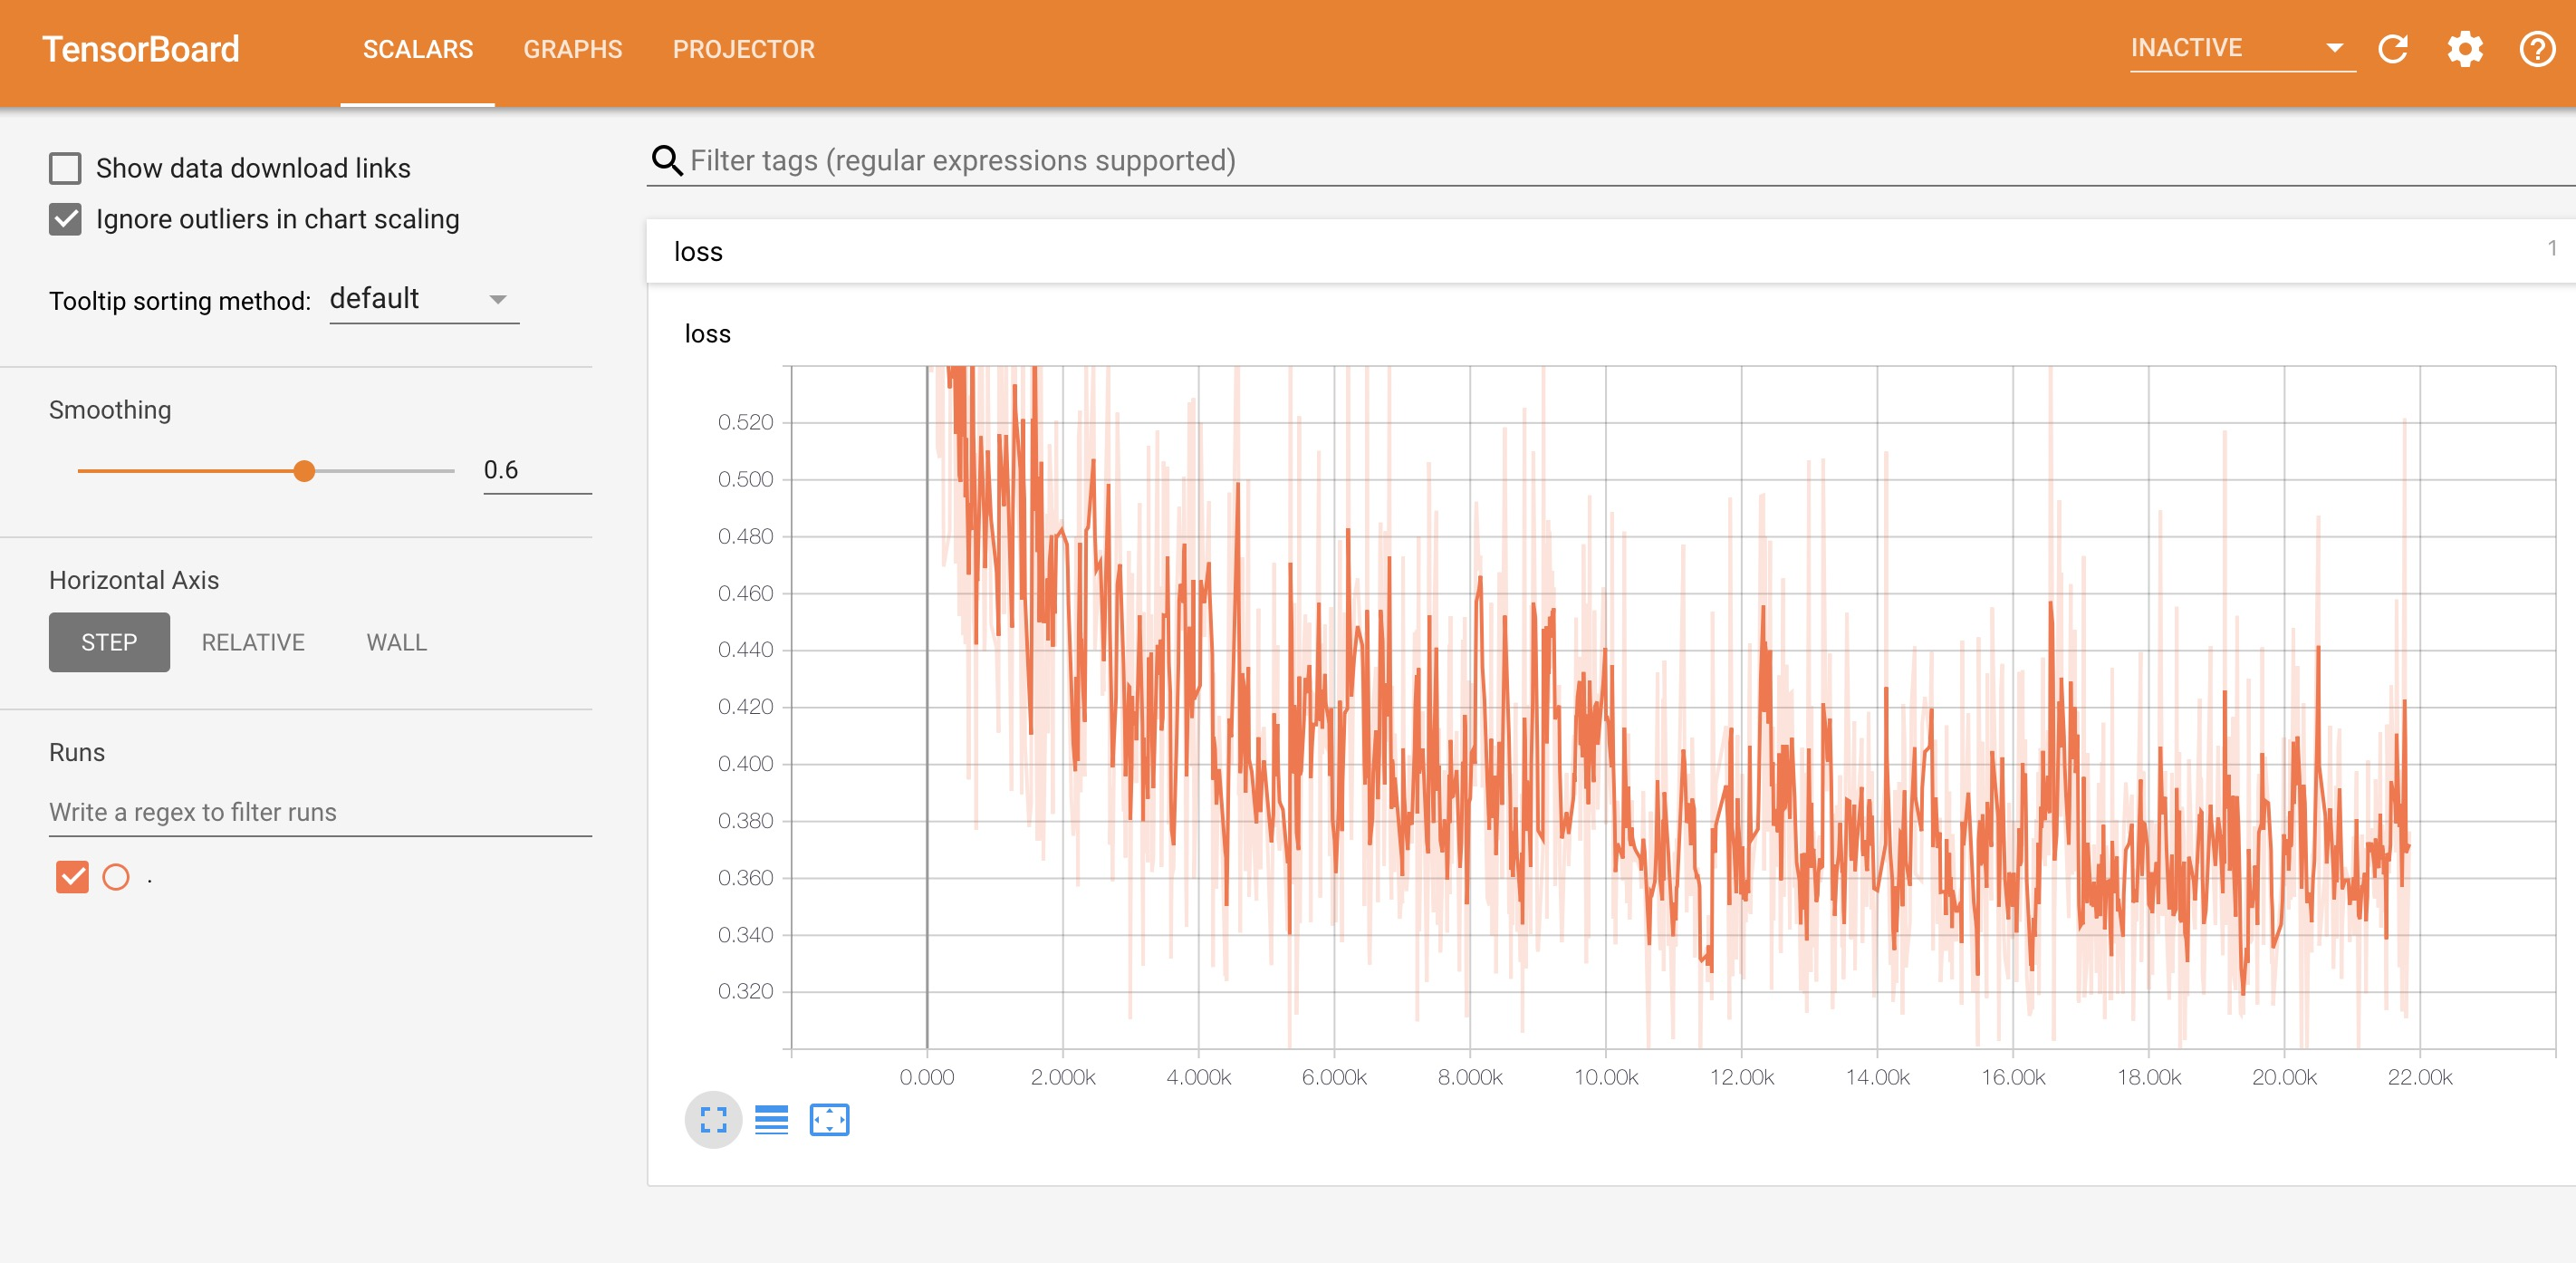

In [19]:
from IPython.display import Image
Image("loss_function.jpg")